# <center> Travaux pratiques d’IA
## <center> Série 5: Naive Bayes & Logistic Regression

### Données
1. Les données à utiliser pour ce TP se trouvent dans les fichiers data_train.csv et data_test csv.
    Il s’agit de prédire l’achat d’un produit en fonction du sexe, de l’âge et du salaire d’un individu.
2. Les 3 premières colonnes spécifient les covariables tandis que la dernière colonne correspond aux labels.
3. Le fichier data_test.csv sert à évaluer les performances des modèles développés à partir des données du fichier data_train.csv.
4. Il est recommandé d’utiliser pandas et/ou NumPy pour manipuler les données. Notamment la méthode get_dummies de pandas vous permet de convertir la première covariable en deux covariables binaires.

### 1 Naive Bayes
Le but de cette section est d’implémenter Naive Bayes. Voici les différentes étapes à accomplir:

1. Calculer la distribution empirique des labels.

In [45]:
import csv
import numpy as np

def convert_csv2array(name: str) -> tuple[np.ndarray, np.ndarray]:
    """
    Convert a csv file into numpy array

    Parameters
    ----------
    name: string
        Path to the file

    Return value
    ------------
    header and data of csv
    """
    file = open(name, 'r')
    data = []
    reader = csv.reader(file)
    for line in reader:
        data.append(line)
    data = np.array(data)
    return data[0, :], data[1:, :]

header, data = convert_csv2array('data_train.csv')

def ampiric_distribution(data: np.ndarray, target: int) -> float:
    """
    Get parameter of bernoulli distribution from a set of values

    Parameters
    ----------
    data: np.ndarray
        set of values
    target: int
        Column target to compute ampiric distribution

    Return value
    ------------
    The parameter p of the bernoulli distribution
    """
    return np.sum(data[:, target].astype(int))/len(data)

print(ampiric_distribution(data, 3))

0.3


2. Pour chaque valeur des labels, estimer les paramètres des distributions des covariables.

In [46]:
def distrib_param(data: np.ndarray, header: np.ndarray, target: int):
    """
    Get parameters of all distributions of a set of label and covariables

    Parameters
    ----------
    data: np.ndarray
        Data to compute
    header: np.ndarray
        Header of the data
    target: int
        Column target for the label

    Return value
    ------------
    dict contain labels with parameter of the distribution of the labels, and parameter of the distributions of each variable
    """
    result = {}
    values = np.unique(data[:, target])
    for i in range(len(values)):
        newdata = data[data[:, target] == values[i]]
        tmp = {}
        for j in range(len(data[0])):
            if j != target:
                tmp_2 = {}
                newvalues, count = np.unique(newdata[:, j], return_counts = True)
                if len(newvalues) == 2:
                    for k in range(len(newvalues)):
                        tmp_2[newvalues[k]] = count[k] / len(newdata)
                else:
                    tmp_2["Mean"] = np.mean(newdata[:, j].astype(float))
                    tmp_2["Variance"] = np.var(newdata[:, j].astype(float))
                tmp[header[j]] = tmp_2
        result[values[i]] = (len(newdata) / len(data), tmp)
    return result

print(distrib_param(data, header, 3))

{'0': (0.7, {'Gender': {'Female': 0.49159663865546216, 'Male': 0.5084033613445378}, 'Age': {'Mean': 32.26890756302521, 'Variance': 64.32264670574112}, 'EstimatedSalary': {'Mean': 60100.84033613445, 'Variance': 625023444.6719865}}), '1': (0.3, {'Gender': {'Female': 0.5490196078431373, 'Male': 0.45098039215686275}, 'Age': {'Mean': 45.0, 'Variance': 79.66666666666667}, 'EstimatedSalary': {'Mean': 96549.01960784313, 'Variance': 1617855440.2153018}})}


3. Implémenter la fonction de densité gausienne et la fonction de probabilité de Bernoulli.

In [47]:
def gaussian_density_function(x: float, mean: float, var: float) -> float:
    """
    Compute the probability of x for a given gaussian density function, obtained thanks to mean and variance.

    Parameters
    ----------
    x: float
        value given to the pdf
    mean: float
        mean of the gaussian distribution
    var: float
        variance of the gaussian distribution

    Return value
    ------------
    The probability of x
    """
    return (1/np.sqrt(var * 2 * np.pi)) * np.exp((-1/2)* ((x - mean)/np.sqrt(var))**2)

def bernoulli_density_function(x: float, p: float) -> float:
    """
    Compute the probability of x for a given bernoulli density function, obtained thanks to p parameter.

    Parameters
    ----------
    x: float
        value given to the pdf
    p: float
        parameter of the bernoulli distribution

    Return value
    ------------
    The probability of x
    """
    return (p ** x)((1 - p) ** (1 - x))

4. Étant donné de nouvelles covariables, prédire les labels correspondants

In [48]:
def naive_base(distrib: dict, header: np.ndarray, data: np.ndarray):
    """
    This function is a naive Bayes classifier and give the result of the estimation for a data given

    Parameters
    ----------
    distrib: dict
        Parameter of all distributions obtained thanks to a set of data
    header: np.ndarray
        header of the data
    data: np.ndarray
        data to estimate

    Return value
    ------------
    The estimation of the given data    
    """
    values_keys = list(distrib.keys())
    maximum = 0
    value = values_keys[0]
    for i in values_keys:
        denom = 1
        for j in range(len(header)):
            if list(distrib[i][1][header[j]].keys())[0] == "Mean" or list(distrib[i][1][header[j]].keys())[1] == "Mean":
                denom *= gaussian_density_function(float(data[j]), distrib[i][1][header[j]]["Mean"], distrib[i][1][header[j]]["Variance"])
            else:
                denom *= distrib[i][1][header[j]][data[j]]

        if denom * distrib[i][0] > maximum:
            maximum = denom
            value = i
    return int(value)

FN, FP, TN, TP = range(4)


def eval_naive_base(data: np.ndarray, data_test: np.ndarray, header: np.ndarray, target: int, prediction: bool = False):
    """
    Function used to evaluate the performance of the naive base classifier on a given test dataset

    Parameters
    ----------
    data: np.ndarray
        data used to train the classifier
    header: np.ndarray
        header of the data
    data_test: np.ndarray
        test dataset
    target: int
        Target column contains label
    prediction: bool
        Indicate if we must return performance of naive base classifier or prediction obtained for each data

    Return values
    -------------
    The probability of false negative, false positive, true negative, true positive, or the prediction of each data
    """
    target_values = data_test[:, target].astype(int)
    data_test = np.delete(data_test, target, 1)
    header_test = np.delete(header, target)

    FN_count = 0
    FP_count = 0
    TN_count = 0
    TP_count = 0

    predict = []
    for i in range(len(data_test)):
        result = naive_base(distrib_param(data, header, target), header_test, data_test[i])

        predict.append(result)

        if result == 1 and target_values[i] == 1:
            TP_count += 1
        elif result == 0 and target_values[i] == 0:
            TN_count += 1
        elif result == 1 and target_values[i] == 0:
            FP_count += 1
        elif result == 0 and target_values[i] == 1:
            FN_count += 1

    if prediction:
        return predict
    
    return FN_count / len(data_test), FP_count / len(data_test), TN_count / len(data_test), TP_count / len(data_test)


_, data_test = convert_csv2array('data_test.csv')

print(eval_naive_base(data, data_test, header, 3, True))


[1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0]


### 2 Logistic Regression
Le but de cette section est d’implémenter Logistic Regression. On suppose donc le modèle
suivant:
$$yi \approx^{ind} Bernoulli(p_i), p_i = \sigma(w^T x_i + b), \sigma(z) = \frac{1}{1+exp−z}$$

1. Sur papier, dériver:

(a) $p(y_i|x_i; w, b)$

$$p(y_i|x_i; w, b) = \boxed{p_i^{y_i}(1 - p_i)^{1 - y_i}}$$

(b) $log(p(y_i|x_i; w, b))$

$$log(p(y_i|x_i; w, b))$$
$$= log(p_i^{y_i}(1 - p_i)^{1 - y_i})$$
$$= log(p_i^{y_i}) + log((1 - p_i)^{1 - y_i})$$
$$= \boxed{y_i log(p_i) + (1 - y_i)log(1 - p_i)}$$

(c) $\frac{d\sigma(z)}{dz}$ comme une fonction de $\sigma$

$$\frac{d\sigma(z)}{dz}$$
$$= ((1 + e^{-z})^{-1})'$$
$$= -1 \times - e ^{-z} \times (1 + e^{-z})^{-2}$$
$$=\frac{e^{-z}}{(1 + e^{-z})^2}$$
$$=\frac{1}{1 + e^{-z}}\frac{e^{-z}}{1 + e^{-z}}$$
$$= \sigma (z) \frac{e^{-z}}{1 + e^{-z}}$$
$$= \sigma (z) \frac{1 + e^{-z} - 1}{1 + e^{-z}}$$
$$= \sigma (z) (\frac{1 + e^{-z}}{1 + e^{-z}} - \frac{1}{1 + e^{-z}})$$
$$= \sigma (z) (1 - \frac{1}{1 + e^{-z}})$$
$$= \boxed{\sigma (z) (1 - \sigma (z))}$$

(d) $\frac{dlog(p(y_i|x_i;w,b))}{dw_j}$

$$\frac{dlog(p(y_i|x_i;w,b))}{dw_j}$$

$$=\frac{y_i log(p_i) + (1 - y_i)log(1 - p_i)}{dw_j}$$
$$=y_i \frac{log(p_i)}{dw_j} + (1 - y_i)\frac{log(1 - p_i)}{dw_j}$$
$$=y_i \frac{log(\sigma (z))}{dw_j} + (1 - y_i)\frac{log(1 - \sigma (z))}{dw_j},\ z = w^T x_i + b$$
$$=y_i \frac{1}{\sigma (z)}\frac{d}{dw_j}\sigma (z) + (1 - y_i)\frac{1}{1 - \sigma (z)}\frac{d}{dw_j}(1 - \sigma (z))$$

On a:
$$\frac{d}{dw_j} z = \frac{d}{dw_j}(w^T x_i + b) \Leftrightarrow \frac{dz}{dw_j} = x_{ij} \Leftrightarrow \frac{d}{dw_j} = \frac{d}{dz}x_{ij}$$

Donc:
$$=y_i \frac{1}{\sigma (z)}\frac{d}{dz}x_{ij}\sigma (z) + (1 - y_i)\frac{1}{1 - \sigma (z)}\frac{d}{dz}x_{ij}(1 - \sigma (z))$$
$$=y_i \frac{1}{\sigma (z)}\frac{d}{dz}\sigma (z)x_{ij} + (1 - y_i)\frac{1}{1 - \sigma (z)}(-\frac{d}{dz} \sigma (z)x_{ij})$$
$$=y_i \frac{1}{\sigma (z)}\sigma (z) (1 - \sigma (z)) x_{ij} + (1 - y_i)\frac{1}{1 - \sigma (z)}(- \sigma (z))(1 - \sigma(z))x_{ij}$$
$$=y_i (1 - \sigma (z)) x_{ij} - (1 - y_i)\sigma (z)x_{ij}$$
$$=y_i x_{ij} - y_i \sigma (z) x_{ij} + (y_i - 1)\sigma (z)x_{ij}$$
$$=y_i x_{ij} + (y_i - 1 - y_i)\sigma (z)x_{ij}$$
$$=\boxed{(y_i - \sigma(z))x_{ij}}$$

(e) $\frac{dlog(p(yi|xi;w,b))}{db}$

$$\frac{dlog(p(yi|xi;w,b))}{db}$$

$$=\frac{d}{db}(y_i log(p_i) + (1 - y_i)log(1 - p_i))$$
$$=y_i \frac{d}{db}log(p_i) + (1 - y_i)\frac{d}{db}log(1 - p_i)$$
$$=y_i \frac{1}{p_i}\frac{d}{db} p_i + (1 - y_i) \frac{1}{1 - p_i} \frac{d}{db}(1 - p_i)$$
$$=y_i \frac{1}{\sigma (z)}\frac{d}{db} \sigma(z) + (1 - y_i) \frac{1}{1 - \sigma (z)} \frac{d}{db}(1 - \sigma (z)),\ z = w^T x_i + b$$

On a:

$$\frac{d}{db} z = \frac{d}{db}(w^T x_i + b) \Leftrightarrow \frac{dz}{db} = 1 \Leftrightarrow \frac{d}{db} = \frac{d}{dz}$$

Donc:
$$y_i \frac{1}{\sigma (z)}\frac{d}{db} \sigma(z) + (1 - y_i) \frac{1}{1 - \sigma (z)} \frac{d}{db}(1 - \sigma (z))$$
$$=y_i \frac{1}{\sigma (z)}\frac{d}{dz} \sigma(z) + (1 - y_i) \frac{1}{1 - \sigma (z)} \frac{d}{dz}(1 - \sigma (z))$$
$$=y_i \frac{1}{\sigma (z)}\frac{d}{dz} \sigma(z) - (1 - y_i) \frac{1}{1 - \sigma (z)} \frac{d}{dz}\sigma (z)$$
$$=y_i \frac{1}{\sigma (z)}\sigma(z) (1 - \sigma (z)) - (1 - y_i) \frac{1}{1 - \sigma (z)} \sigma (z)(1 - \sigma (z))$$
$$=y_i (1 - \sigma (z)) - (1 - y_i)\sigma (z)$$
$$=y_i - y_i \sigma (z) + (y_i - 1)\sigma (z)$$
$$=y_i + (y_i - 1 - y_i)\sigma (z)$$
$$=\boxed{y_i - \sigma (z)}$$

2. Implémenter une fonction train_logistic_regression qui prend en arguments:

    (a) Une matrice de covariables X
  
    (b) Un vecteur de labels y

    (c) Un vecteur de poids initial w

    (d) Une valeur de biais initiale

    (e) Un nombre d’itérations num_iters
    
    (f) Un taux d’apprentissage learning_rate et qui renvoit les poids et le biais entraînés par descente de gradient à minimiser
    $$−\sum_{i = 1}^N log(p(y_i|x_i; w, b))$$
    avec $N$ le nombre d’exemples d’entraînement.


Comme on a $−\sum_{i = 1}^N log(p(y_i|x_i; w, b))$, alors on a notre dérivée par rapport à $dw_j$ qui nous donne: 
$$\frac{d}{dw_j}(−\sum_{i = 1}^N log(p(y_i|x_i; w, b)))$$
$$= −\sum_{i = 1}^N (y_i - \sigma(z))x_{ij}$$
$$=\sum_{i = 1}^N (\sigma(z) - y_i)x_{ij}$$

Et notre dérivée par rapport à $db$ qui nous donne:
$$\frac{d}{db}(−\sum_{i = 1}^N log(p(y_i|x_i; w, b)))$$
$$= −\sum_{i = 1}^N (y_i - \sigma(z))$$
$$=\sum_{i = 1}^N (\sigma(z) - y_i)$$

In [36]:
def sigma(z):
    """
    This function implements the sigmoid function.
    The sigmoid function takes the value z and return a value between 0 and 1.

    Parameters
    ----------
    z:
        value given to the function
    
    Return value
    ------------
    return a value between 0 and 1
    """
    return 1. / (1. + np.exp(-z))

def gradient_w(X: np.ndarray, y: np.ndarray, w: np.ndarray, b: float):
    """
    This function calculate the derivate compared to the weights w of the function to minimise, given above

    Parameters
    ----------
    X: np.ndarray
        Matrix of covariables
    y: np.ndarray
        Vector of labels
    w: np.ndarray
        Vector of initial weights
    b: float
        Value of initial bias
    
    Return value
    ------------
    return the result of the derivate compared to the weights w of the function to minimise.
    """
    return (sigma(X @ w + b) - y) @ X

def gradient_b(X: np.ndarray, y: np.ndarray, w: np.ndarray, b: float):
    """
    This function calculate the derivate compared to the bias b of the function to minimise, given above

    Parameters
    ----------
    X: np.ndarray
        Matrix of covariables
    y: np.ndarray
        Vector of labels
    w: np.ndarray
        Vector of initial weights
    b: float
        Value of initial bias
    
    Return value
    ------------
    return the result of the derivate compared to the bias b of the function to minimise.
    """
    return np.sum(sigma(X @ w + b) - y)

def covariable_matrix(data: np.ndarray, target: int, maximum: list = [1, 60, 150000]) -> np.ndarray:
    """
    This function is a preprocessing step in logistic regression allowing to have all the values in the same order of size.

    Parameters
    ----------
    data: np.ndarray
        Data to use to compute covariable matrix
    target: int
        target of the label column
    maximum: list
        List of maximum of each column to normalize the covariable matrix

    Return value
    ------------
    A covariable matrix with all the values in the same order of size
    """
    data[data == "Male"] = 1
    data[data == "Female"] = 0
    X = np.delete(data, target, 1)
    X = X.astype(float)
    for i in range(X.shape[1]):
        X[:, i] /= maximum[i]
    return X


def train_logistic_regression(X: np.ndarray, y: np.ndarray, w: np.ndarray, b: float, num_iters: int, learning_rate: float):
    """
    This function implements the training process for logistic regression. It compute the optimal parameters w and b thanks to a gradient descent.

    Parameters
    ----------
    X: np.ndarray
        Matrix of covariables
    y: np.ndarray
        Vector of labels
    w: np.ndarray
        Vector of initial weights
    b: float
        Value of initial bias
    num_iters: int
        Number of iterations
    learning_rate: float
        define how the function will converge. Too big values give bad results and too smal values not converge or converge too slowly

    Return value
    ------------
    Optimal parameters w and b for the initial configuration and parameters
    """
    gradient = [w, b]
    for i in range(num_iters):
        gradient[0] = gradient_w(X, y, w, b)
        gradient[1] = gradient_b(X, y, w, b)
        w -= learning_rate * gradient[0]
        b -= learning_rate * gradient[1]
    return w, b

def logistic_regression(data: np.ndarray, target: int, num_iters: int, learning_rate: float):
    """
    This function is used to convert data to parameters to the function above

    Parameters
    ----------
    data: np.ndarray
        Data used to get optimal parameters w and b
    target: int
        Target column of label
    num_iters: int
        Number of iterations
    learning_rate: float
        define how the function will converge. Too big values give bad results and too smal values not converge or converge too slowly

    Return value
    ------------
    Optimal parameters w and b for the initial configuration and parameters
    """
    X = covariable_matrix(data, target)
    y = data[:, target].astype(int)
    w = np.zeros(len(X[0]))
    b = 0.0
    return train_logistic_regression(X, y, w, b, num_iters, learning_rate)

w, b = logistic_regression(data, 3, 1000, 0.005)

print(f"Parameter w: {w}")
print(f"Parameter b: {b}\n")

def evaluate(data: np.ndarray, target: int, w: np.ndarray, b: float, threshold: float = 0.5):
    """
    This function is used to evaluate the logistic regression model on a given dataset.

    Parameters
    ----------
    data: np.ndarray
        dataset to evaluate
    target: int
        target column of label
    w: np.ndarray
        Vector of initial weights
    b: float
        Value of initial bias
    threshold: float
        All values greater than threshold will have a label of 1 and all values less than threshold will have a label of 0

    Return value
    ------------
    Return a set of labels of estimated data
    """
    X = covariable_matrix(data, target)
    result = sigma(X @ w + b)
    result[result >= threshold] = 1
    result[result < threshold] = 0
    return result

print(evaluate(data_test, 3, w, b))

def eval_regression(data: np.ndarray, data_test: np.ndarray, header: np.ndarray, target: int, num_iters: int = 1000, learning_rate: float = 0.001):
    """
    Function used to evaluate the performance of the logistic regression on a given test dataset

    Parameters
    ----------
    data: np.ndarray
        data used to train the regression
    data_test: np.ndarray
        test dataset
    header: np.ndarray
        header of the data
    target: int
        Target column contains label
    num_iters: int
        used to train the regression
    learning_rate: float
        used to train the regression. Give the learning rate.

    Return values
    -------------
    The probability of false negative, false positive, true negative, true positive
    """
    FN_count = 0
    FP_count = 0
    TN_count = 0
    TP_count = 0
    y = data_test[:, target].astype(int)
    w, b = logistic_regression(data, target, num_iters, learning_rate)
    result = evaluate(data_test, target, w, b)
    for i in range(len(y)):
        if result[i] == 0 and y[i] == 1:
            FN_count += 1
        elif result[i] == 1 and y[i] == 0:
            FP_count += 1
        elif result[i] == 0 and y[i] == 0:
            TN_count += 1
        elif result[i] == 1 and y[i] == 1:
            TP_count += 1
    return FN_count / len(y), FP_count / len(y), TN_count / len(y), TP_count / len(y)

print(eval_regression(data, data_test, header, 3))


Parameter w: [0.28625294 9.95965667 5.40224131]
Parameter b: -10.099159412529197

[1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0.
 1. 1. 1. 1. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 1. 1. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
(0.4166666666666667, 0.0, 0.31666666666666665, 0.26666666666666666)


### 3 Evaluation
Comparer les performances des modèles développés en les évaluant sur les données de data_train.csv
et data_test.csv selon les métriques suivantes: accuracy, precision, recall, F1 score.

In [37]:
def accuracy(data: np.ndarray, data_test: np.ndarray, header: np.ndarray, target: int, regression: bool = False, num_iters: int = 1000, learning_rate: float = 0.005) -> float:
    """
    Return the error rate of the model for a given set of test datas

    Parameters
    ----------
    data: np.ndarray
        data used to train the regression
    data_test: np.ndarray
        test dataset
    header: np.ndarray
        header of the data
    target: int
        Target column contains label
    regression: bool
        Indicate if we evaluate the regression or the naive base model

    Return value
    ------------
    Return the probability of making an error in our prediction
    """
    if regression:
        fn, fp, tn, tp = eval_regression(data, data_test, header, target, num_iters, learning_rate)
    else:
        fn, fp, tn, tp = eval_naive_base(data, data_test, header, target)
    return (fp + fn)/(tp + tn + fp + fn)

def precision(data: np.ndarray, data_test: np.ndarray, header: np.ndarray, target: int, regression: bool = False, num_iters: int = 1000, learning_rate: float = 0.005):
    """
    Return the precision of the model for a given set of test datas

    Parameters
    ----------
    data: np.ndarray
        data used to train the regression
    data_test: np.ndarray
        test dataset
    header: np.ndarray
        header of the data
    target: int
        Target column contains label
    regression: bool
        Indicate if we evaluate the regression or the naive base model
    num_iters: int
        used to train the regression
    learning_rate: float
        used to train the regression. Give the learning rate.

    Return value
    ------------
    Return the precision and the recall of the model
    """
    if regression:
        fn, fp, tn, tp = eval_regression(data, data_test, header, target, num_iters, learning_rate)
    else:
        fn, fp, tn, tp = eval_naive_base(data, data_test, header, target)
    return tp / (tp + fp), tp / (tp + fn)

def f1_score(data: np.ndarray, data_test: np.ndarray, header: np.ndarray, target: int, regression: bool = False, num_iters: int = 1000, learning_rate: float = 0.005) -> float:
    """
    Return the f1 score of the model for a given set of test datas

    Parameters
    ----------
    data: np.ndarray
        data used to train the regression
    data_test: np.ndarray
        test dataset
    header: np.ndarray
        header of the data
    target: int
        Target column contains label
    regression: bool
        Indicate if we evaluate the regression or the naive base model
    num_iters: int
        used to train the regression
    learning_rate: float
        used to train the regression. Give the learning rate.
    
    Return value
    ------------
    Return the f1 score of the model
    """
    if regression:
        p, r = precision(data, data_test, header, target, regression, num_iters, learning_rate)
    else:
        p, r = precision(data, data_test, header, target, regression)
    return (2 * p * r) / (p + r)

In [28]:
# Get optimal parameters w and b for logistic regression
maximum = 0
index = 0
learning_rate = np.linspace(0.001, 1, 1000)
for i in range(len(learning_rate)):
    tmp = f1_score(data, data_test, header, 3, True, 1000, learning_rate[i])
    tmp_2 = f1_score(data, data, header, 3, True, 1000, learning_rate[i])
    if (tmp + tmp_2) / 2 > maximum:
        maximum = (tmp + tmp_2) / 2
        index = i
print(learning_rate[index])
    

KeyboardInterrupt: 

In [38]:
print(f1_score(data, data_test, header, 3, True, 1000, 0.08))

0.8421052631578947


Pour savoir avec quel `learning rate` je vais travailler, j'ai testé différentes valeurs et j'ai maximisé le f1_score pour le `learning rate` choisi, en prenant la valeur moyenne entre le f1 score obtenu grâce aux données de test et le f1 score obtenu grâce aux données d'entrainement.

ValueError: `bins` must increase monotonically, when an array

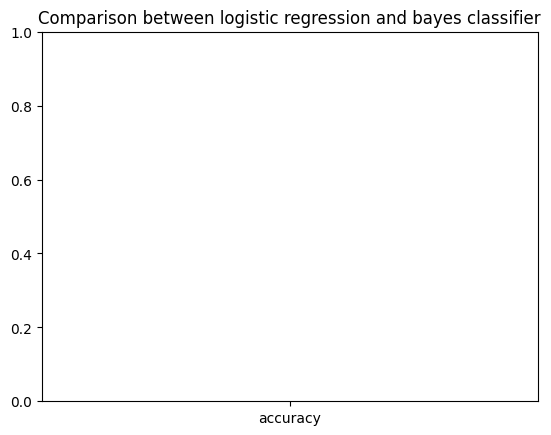

In [49]:
import matplotlib.pyplot as plt

def compare_methods(data: np.ndarray, data_test: np.ndarray, header: np.ndarray, target: int, num_iters: int, learning_rate: float):
    accuracy_regression = accuracy(data, data_test, header, target, True, num_iters, learning_rate)
    accuracy_bayes = accuracy(data, data_test, header, target, False)

    precision_regression = precision(data, data_test, header, target, True, num_iters, learning_rate)
    precision_bayes = precision(data, data_test, header, target, False)

    f1_score_regression = f1_score(data, data_test, header, target, True, num_iters, learning_rate)
    fu_score_bayes = f1_score(data, data_test, header, target, False)

    plt.figure()
    plt.title("Comparison between logistic regression and bayes classifier")
    plt.hist(["accuracy", "precision", "recall", "f1 score"], [accuracy_regression, precision_regression[0], precision_regression[1], f1_score_regression])
    plt.legend()
    plt.show()


compare_methods(data, data_test, header, 3, 1000, 0.032)
